# Importing libraries and classes

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams


from nam.data import load_gallup_data, load_housing_data, load_sklearn_housing_data, load_breast_data

# Define the experiments configurations

In [3]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.5, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.5, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.5, logdir='output', lr=0.0003, num_basis_functions=1000, num_epochs=1, num_folds=5, num_models=1, num_splits=3, num_workers=16, optimizer='adam', output_regularization=0.5, regression=False, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=True)


In [4]:
### the config parameters can be updated like this
config.num_epochs = 10

# Data

NAM Library contains two types of Data Classes
- **NAMDataset**: spliting the data info train, val, test
- **FoldedDataset(NAMDataset)**: performing cross validation on the dataset with multiple folds

Also, there are some predefined loading functions stores in `nam/data/datasets.py` and user can define their loading function there 

In [22]:
dataset = load_gallup_data(config, 
                           data_path='data/GALLUP.csv', 
                           features_columns= ["income_2", "WP1219", "WP1220"])

# dataset = load_sklearn_housing_data(config)

# dataset = load_breast_data(config)

Found `Nulls` values in the dataset
Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
                  Missing Values  % of Total Values
weo_gdpc_con_ppp            2540              1.894
WP1220                        15              0.011


In [23]:
dataset[0]

(tensor([-0.9994, -1.0000, -0.8118]), tensor([0.]))

### Getting the training dataloaders

In [24]:
dataloaders = dataset.train_dataloaders()

## Define NAM Model

In [25]:
model = NAM(
  config=config,
  name="NAM_GALLUP",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=184)
        (1): LinReLU(in_features=184, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)

## Training loop

In [26]:
for fold, (trainloader, valloader) in enumerate(dataloaders):

    tb_logger = TensorBoardLogger(save_dir=config.logdir,
                                name=f'{model.name}',
                                version=f'fold_{fold + 1}')

    checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                        "/{epoch:02d}-{val_loss:.4f}",
                                        monitor='val_loss',
                                        save_top_k=config.save_top_k,
                                        mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(logger=tb_logger,
                       max_epochs=config.num_epochs,
                       checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel,
              train_dataloader=trainloader,
              val_dataloaders=valloader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 84.8 K
-------------------------------
84.8 K    Trainable params
0         Non-trainable params
84.8 K    Total params
0.339     Total estimated model params size (MB)
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Testing the trained model

In [27]:
trainer.test(test_dataloaders=dataset.test_dataloaders())

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.6458333134651184,
 'Accuracy_metric_epoch': 0.6506563425064087,
 'test_loss': 236.77108764648438,
 'test_loss_epoch': 237.080322265625}
--------------------------------------------------------------------------------


[{'test_loss': 236.77108764648438,
  'test_loss_epoch': 237.080322265625,
  'Accuracy_metric_epoch': 0.6506563425064087,
  'Accuracy_metric': 0.6458333134651184}]

# Nam Visualization

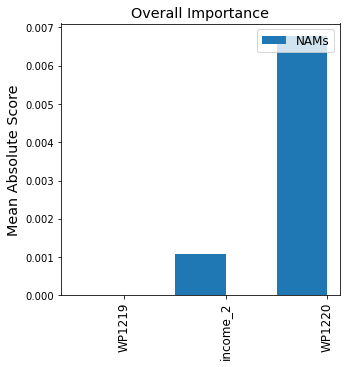

In [28]:
fig = plot_mean_feature_importance(litmodel.model, dataset)

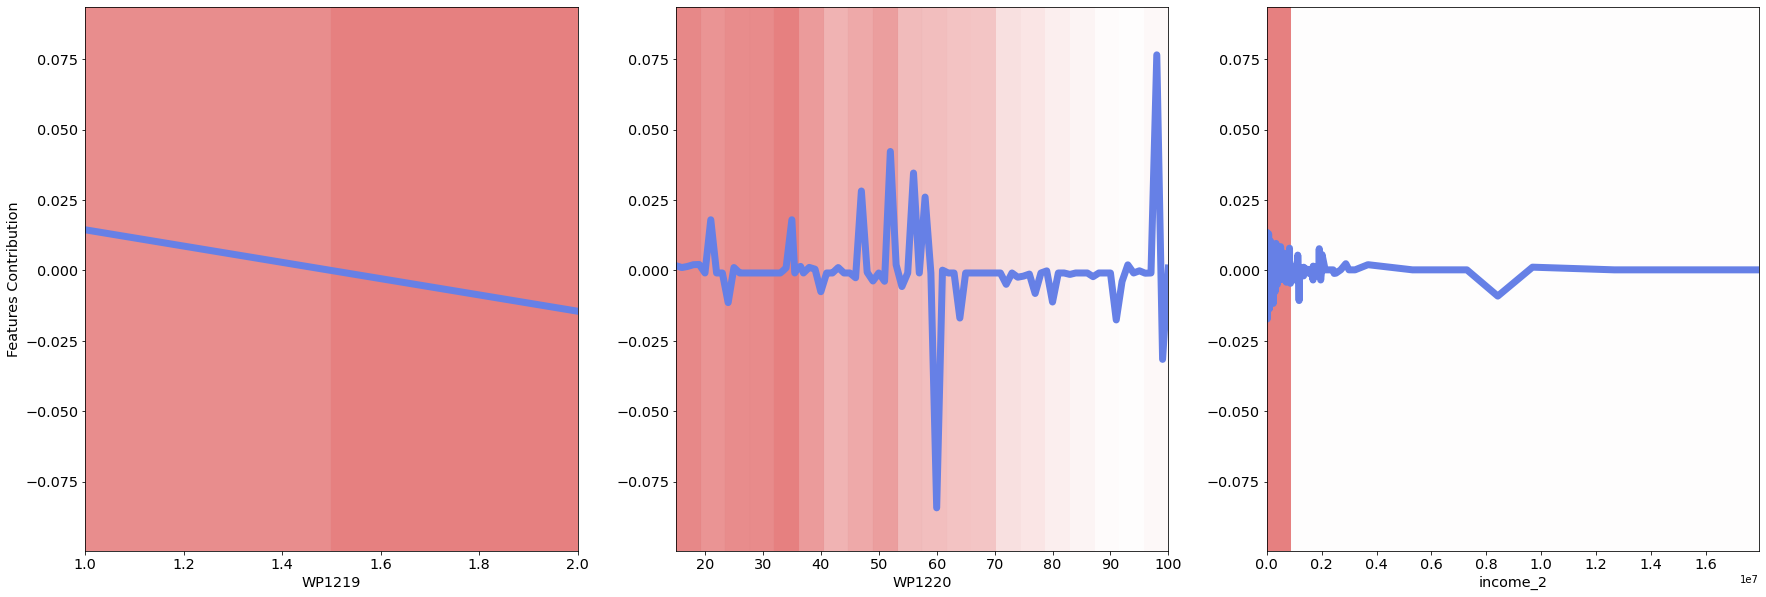

In [32]:
fig = plot_nams(litmodel.model, dataset, num_cols= 3)

# Nam Visualization

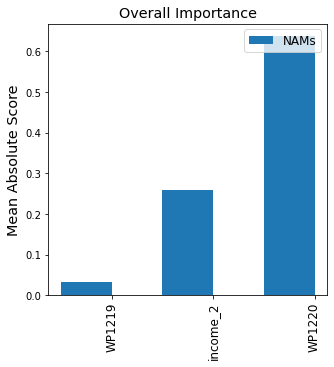

In [11]:
fig = plot_mean_feature_importance(litmodel.model, dataset)

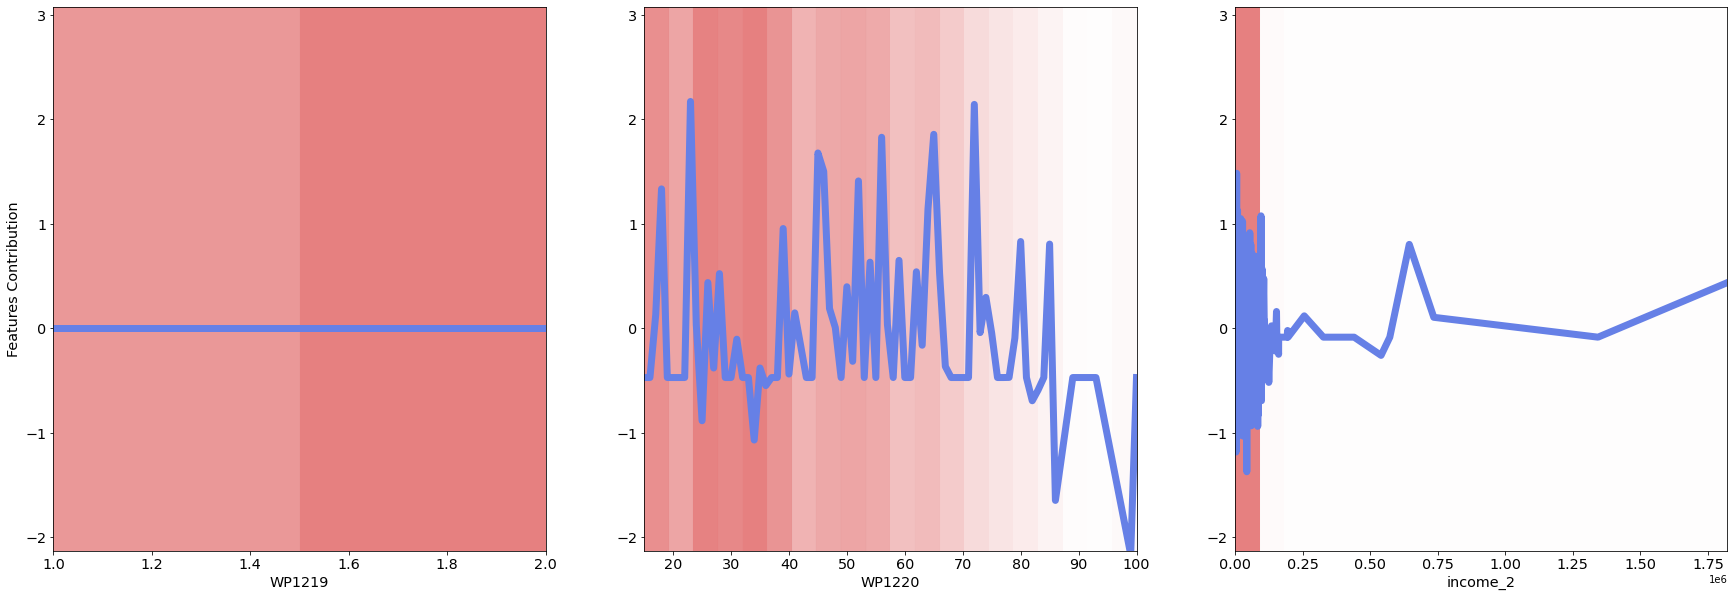

In [13]:
fig = plot_nams(litmodel.model, dataset, num_cols= 3)